In [11]:
#Librairy 
import pandas as pd
import scipy as sc
import seaborn as sns
import sklearn
import re
import requests
import json
import numpy as np
import sys
import umap

from sklearn.decomposition import PCA
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import r2_score, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
import sklearn.feature_extraction.text as text
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.preprocessing import Normalizer, MinMaxScaler

import statsmodels.api as sm
### Gensim is outside the anaconda distribution ###
### uncomment to install Gensim ###
# !{sys.executable} -m pip install gensim
import gensim
import gensim.downloader as model_api

# 1. App Review NLP work

This question uses the Apple App review dataset that you generated in the "Pulling online data" workshop. Your dataset should have at least 3-5 different applications, with data from a few countries.

**1.1** Using the bag-of-words or TF-IDF vector model (from SKLearn), cluster the reviews into 5 clusters. Measure the accuracy of the cluster overlap against the real review scores.

**1.2** Now use a sentence embedding using on of the `gensim` pre-trained word embedding models to achieve the same in clustering. Get the best classification accuracy score you can on the 5-star review scale targer using all unsupervised methods you want.

**1.3** Using any method you want (pre-trained models, dimensionality reduction, feature engineering, etc.) make the best **regression** model you can to predict the 5 star rating. Rate the accuracy in regression terms (mean squared error) and in classification terms (accuracy score, etc.)

**1.4** Do the same as in 1.3, but use a classification model. Are classification models better or worse to predict a 5-point rating scale? Explain in a few paragraphs and justify with metrics.


In [16]:

apps = ['strava', 'zwift', 'trainingpeaks', 'komoot']
ids = ['426826309', '1134655040', '408047715', '447374873']

countries = ['us','gb','ca','au']


In [17]:
df = pd.DataFrame()

for id in ids: 
    for c in countries:
        pg = 1

        r.status_code = 200
        while r.status_code == 200:
            try:
                url = f'https://itunes.apple.com/{c}/rss/customerreviews/id={id}/page={pg}/sortby=mostrecent/json'
                r = requests.get(url)
                j = json.loads(r.content)
                reviews = {}
                reviews['version'] = [ e['im:version']['label'] for e in j['feed']['entry'] ]
                reviews['rating'] = [ e['im:rating']['label'] for e in j['feed']['entry'] ]
                reviews['title'] = [ e['title']['label'] for e in j['feed']['entry'] ]
                reviews['comment'] = [ e['content']['label'] for e in j['feed']['entry'] ]
                reviews['country'] = [c for _ in range(0,len(reviews['version']))]
                reviews['app'] = [id for _ in range(0,len(reviews['version']))]
                pg += 1
            except:
                r.status_code = 999
            
            df = pd.concat([df, pd.DataFrame.from_dict(reviews)])

df['app'] = df['app'].replace(ids,apps)

df = df[['app', 'country', 'version', 'rating', 'title', 'comment']]


In [21]:
print(df.shape)
df.tail()

(6020, 6)


,app,country,version,rating,title,comment
18,komoot,au,9.1.2,5,Cool app,Found it to be very easy to use. I use when ev...
19,komoot,au,9.1.2,5,"Brilliant app, I just use it for bike navigati...",Great app
20,komoot,au,9.1,5,Super easy to use,Love how this app takes you off the main roads...
21,komoot,au,8.4.1,5,Super useful.,"As a traveller from Australia, finding paths a..."
22,komoot,au,6.1,5,Amazing!!!!,This app is revolutionary! Extremely useful an...


### 1.1 Using the bag-of-words or TF-IDF vector model (from SKLearn), cluster the reviews into 5 clusters. Measure the accuracy of the cluster overlap against the real review scores.



In [26]:
df["rating"] = df["rating"].astype(float)

In [27]:
tf = text.TfidfVectorizer()
X = tf.fit_transform(df["comment"])

Xd = X.toarray()
Xd = PCA(5).fit(Xd.T).components_.T
Xd = sm.add_constant(Xd)

pred = Xd @ sc.linalg.inv(Xd.T @ Xd) @ Xd.T @ df['rating'].values
print("OLS R^2: ", r2_score(df['rating'], pred))

OLS R^2:  0.22598044643708892


In [30]:
#bag of words 
vectorizer = CountVectorizer(stop_words='english', ngram_range=(1,2))

df['comment'] = (df['comment'].str.lower()
                              .str.extract('([aA-zZ][\w\s]+)'))
#df['rating'] = df['rating'].astype(int)
df= df.dropna()

X = vectorizer.fit_transform(df['comment'])
wordLabels = vectorizer.get_feature_names()
pd.DataFrame(data = X.toarray(), columns=wordLabels).head()

,10,10 days,10 ironman,10 mins,10 recommend,10 seconds,10 times,10 users,10 years,100,...,zwifting months,zwifting year,ça,ça coche,és,és month,être,être oubliger,útil,útil para
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 1.2 Now use a sentence embedding using on of the gensim pre-trained word embedding models to achieve the same in clustering. Get the best classification accuracy score you can on the 5-star review scale targer using all unsupervised methods you want.

In [32]:

import re

words = df.comment.str.split()
words = pd.DataFrame(words.tolist())

replaceDict = dict({
'{':" ", '}':" ", ',':"", '.':" ", '!':" ", '\\':" ", '/':" ", '$':" ", '%':" ",
'^':" ", '?':" ", '\'':" ", '"':" ", '(':" ", ')':" ", '*':" ", '+':" ", '-':" ",
'=':" ", ':':" ", ';':" ", ']':" ", '[':" ", '`':" ", '~':" ", '@':" "
})

rep = dict((re.escape(k), v) for k, v in replaceDict.items())
pattern = re.compile("|".join(rep.keys()))
def replacer(text):
    return rep[re.escape(text.group(0))]

words = df.comment.str.replace(pattern, replacer).str.lower().str.split()
words = pd.DataFrame(words.tolist())
words

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
0,d,rather,not,change,most,uploads,to,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,the,strava,app,is,difficult,to,trust,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,where,do,i,even,begin,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,a,kick,scooter,is,not,the,same,as,ruining,or,...,None,None,None,None,None,None,None,None,None,None
4,one,major,problem,with,the,app,is,the,inability,to,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5998,found,it,to,be,very,easy,to,use,None,None,...,None,None,None,None,None,None,None,None,None,None
5999,great,app,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
6000,love,how,this,app,takes,you,off,the,main,roads,...,None,None,None,None,None,None,None,None,None,None
6001,as,a,traveller,from,australia,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [34]:
word_vectors = model_api.load("glove-wiki-gigaword-50")

def soft_get(w):
    try:
        return word_vectors[w] #if word vector exists, retrieve it
    except KeyError:
        return np.zeros(word_vectors.vector_size) #if doesnt exist, fill with zeros

def map_vectors(row):
    try:
        res=row.loc[row.notna()].apply(soft_get)
        if len(res) >=1:
            return np.sum(res) #return the sum of the word vectors
        else:
            return np.zeros(word_vectors.vector_size) #if error, return zeros
        # return np.sum(
        #     row.loc[row.notna()].apply(soft_get)
        # )
    except:
        return np.zeros(word_vectors.vector_size)

emb = pd.DataFrame(words.apply(map_vectors, axis=1).tolist())

In [35]:
emb

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,2.038504,0.094051,1.648228,-0.808359,1.330644,2.140536,-0.377590,-1.438798,-0.775140,1.393120,...,0.104135,1.212668,-0.253066,2.114720,-1.129994,0.916973,0.062170,0.134374,-0.232389,3.149503
1,3.166940,0.327077,0.647257,1.536020,2.350684,0.296843,-1.620193,-1.597670,1.604918,-0.279516,...,-0.167698,-1.437386,-0.958572,0.806582,-1.209564,1.191635,-0.688845,0.640813,1.942501,0.374127
2,2.280040,0.255259,-0.171861,-2.190240,1.214720,-1.699340,-2.593070,1.199726,-2.215791,0.008168,...,-2.208644,0.006863,0.350245,2.029116,0.254276,0.418433,0.170323,-1.388462,-1.422680,1.674140
3,3.187843,2.995820,-2.718067,-0.766928,4.705318,5.424036,-4.922913,-4.420483,-1.453810,0.418658,...,-2.639008,1.965982,-1.741109,5.164299,-0.198217,-3.233094,-1.480852,-4.456702,3.631666,-0.377520
4,4.964128,1.826330,1.957861,1.550663,3.106451,2.874672,-3.881573,-2.336233,2.435993,-0.800736,...,0.098752,0.513002,-4.623670,2.897975,-0.571767,2.177930,3.647734,1.924713,0.891681,0.291390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5998,4.750341,-0.821291,0.550575,-0.943714,3.129628,1.271571,-3.071419,-0.732971,-0.883680,0.999128,...,0.392117,0.698076,2.021693,3.221380,0.425410,0.942047,-0.826664,0.185530,0.673533,0.531445
5999,0.373803,0.539250,0.348300,0.895500,0.488553,-0.536110,-0.915180,-1.020160,1.075040,0.918844,...,0.885550,0.150090,-1.593920,-0.061490,0.126140,1.416660,0.094330,-0.309730,0.636120,0.126970
6000,6.452778,2.965620,0.948460,0.899830,2.820662,0.754146,-5.425050,-1.760872,0.771874,-0.815452,...,-1.465702,1.385491,-0.974157,0.567510,0.085325,2.598078,1.030935,-4.194040,2.145931,-0.749100
6001,0.537490,0.854516,-1.587876,-0.539560,1.525540,0.850520,-3.896930,-0.825042,0.630970,-0.820051,...,0.989829,1.025090,0.396644,-0.539502,0.137465,0.548970,-0.955166,-1.179602,1.181540,-0.972045


In [37]:
from sklearn.preprocessing import Normalizer

X = Normalizer().fit_transform(emb)
sgdr = SGDRegressor()
sgdr.fit(X, df.rating)
acc = sgdr.score(X, df.rating)

print(f"Accuracy score: {acc}")

Accuracy score: 0.1830263190009751


### 1.3 Using any method you want (pre-trained models, dimensionality reduction, feature engineering, etc.) make the best regression model you can to predict the 5 star rating. Rate the accuracy in regression terms (mean squared error) and in classification terms (accuracy score, etc.)

In [38]:
#Regression model 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [40]:
vectorizer = CountVectorizer()

In [51]:

X = vectorizer.fit_transform(df['comment'])

Xd = X.toarray()
Xd = PCA(200).fit(Xd.T).components_.T
Xd = sm.add_constant(Xd)

pred = Xd @ sc.linalg.inv(Xd.T @ Xd) @ Xd.T @ df['rating'].values
print("OLS R^2: ", r2_score(df['rating'], pred))

OLS R^2:  0.306647429331787


### 1.4 Do the same as in 1.3, but use a classification model. Are classification models better or worse to predict a 5-point rating scale? Explain in a few paragraphs and justify with metrics.

              precision    recall  f1-score   support

           1       0.95      0.97      0.96      1364
           2       0.98      0.92      0.95       483
           3       0.99      0.91      0.95       449
           4       0.97      0.87      0.91       676
           5       0.95      0.98      0.97      3031

    accuracy                           0.96      6003
   macro avg       0.97      0.93      0.95      6003
weighted avg       0.96      0.96      0.96      6003

accuracy score: 0.9571880726303514


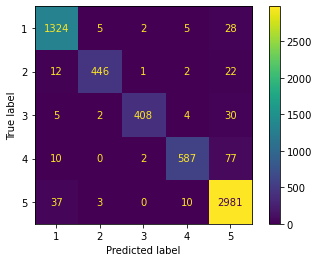

In [47]:
# RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

tf = text.TfidfVectorizer()
X = tf.fit_transform(df['comment'])

Xd = X.toarray()
Xd = PCA(COMPRESSED_SIZE).fit(Xd.T).components_.T 

PCA_df = pd.DataFrame(Xd)
PCA_df


X = PCA_df
y = df.rating
model = RandomForestClassifier().fit(X,y)
preds = model.predict(X)
df['rfc_preds'] = preds


print(classification_report(y, df.rfc_preds))
print(plot_confusion_matrix(model, X, y))
print(f"accuracy score: {accuracy_score(df.rating, df.rfc_preds)}")

# Interpreation 

The Random Forest Classifier allow us to classified the rating in a better way, we are able to identify the intermediate rating scores (i.e 2,3 and 4). The accuracy score is also pretty good. The Randon Forest Classifier tends to give more accurate result because it's apparently one of the most accurate learning algo available and it produces a highly accurate classifier. 

The regression models don't seem to be the right choice for this problem, our r2 score is pretty low. 

## 2. Face data

Here let's apply manifold learning on some face data.

Use the following code:

```
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=30)
```

To get the `faces` dataset.

Use dimensionality reduction so that the darkness of the image is sorted in the first dimension as seen in this picture:

![](isofaces.png)

Then produce a picture similar to this one with your result

In [50]:
from sklearn.datasets import fetch_lfw_people

In [48]:
sns.set()
faces = fetch_lfw_people(min_faces_per_person=30)

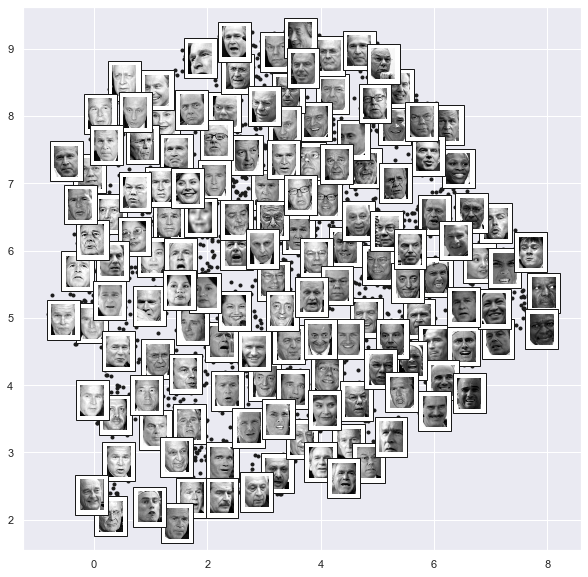

In [49]:

def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

fig, ax = plt.subplots(figsize=(10, 10))
model = umap.UMAP(n_neighbors=5, n_components=2)
plot_components(faces.data, model, images=faces.images[:, ::2, ::2],
                ax=ax, thumb_frac=0.05)